[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FlorianMarquardt/machine-learning-for-physicists/blob/master/2024/05_tutorial_tSNE_sample_code_jax.ipynb)

# Dimensionality Reduction via t-SNE

Example code for the lecture series "Machine Learning for Physicists" by Florian Marquardt

Lecture 5, Tutorial (this is discussed in session 5)

See https://machine-learning-for-physicists.org and the current course website linked there!



The following python code for t-SNE is an original code by the inventor of t-SNE, Laurens van der Maaten. It is available on his website https://lvdmaaten.github.io/tsne/ . 

It is stated on that website: "*You are free to use, modify, or redistribute this software in any way you want, but only for non-commercial purposes. The use of the software is at your own risk; the authors are not responsible for any damage as a result from errors in the software.*"

In [1]:

import numpy as np

import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300 # highres display

# for updating display 
# (very simple animation)
from IPython.display import clear_output

import jax 
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [2]:
#
#  tsne.py
#
# Implementation of t-SNE in Python. The implementation was tested on Python
# 2.7.10, and it requires a working installation of NumPy. The implementation
# comes with an example on the MNIST dataset. In order to plot the
# results of this example, a working installation of matplotlib is required.
#
# The example can be run by executing: `ipython tsne.py`
#
#
#  Created by Laurens van der Maaten on 20-12-08.
#  Copyright (c) 2008 Tilburg University. All rights reserved.

# note by FM: For this notebook, the MNIST example was dropped


# Description of the t-SNE

In this exercise you do some mathematical derivation for t-SNE. 

t-SNE is a non-linear method to compress and classify hidimension data. Assume we have a set of data $\{X_i\}_{i=1}^N$ with very high dimension. For example, pixels of images of human expressions. One woiuld like to extrack key informations from this complex data set. For example, tell the mood according to the expression shown on the image. 

The process of t-SNE is shown below: 

## Step 1:
We construct a probability distribution which shows the "distance" between different data. First we have:
\begin{equation}
    \begin{split}
    S_{j|i} &= \exp (- \beta_i ||X_i - X_j||^2) = \exp (- \beta_i D_{ij}) \\
    P_{j|i} &= \frac{S_{j|i}}{\sum_k S_{k|i} } 
    \end{split}
\end{equation}

and set $p_{i|i}=0$. 
Then the probability distribution $P$ is set as: 
\begin{equation}
P_{ij} = \frac{(S_{j|i} + S_{i|j})}{2 \sum_{k,l} S_{k|l} + S_{l|k}}
\end{equation}

The value of $\beta_i$ are chosen with a bicestion searching such that $P_{j|i}$ have the same conditional entropy.

## Step 2:
For arbitrary low dimension data $\{Y_i\}_{i=1}^N$, we define the probability distribution $Q$ as:
\begin{equation}
    \begin{split}
    R_{ij} &= \frac{1}{1 + ||Y_i - Y_j||^2} \\
    Q_{ij} &= \frac{R_{ij}}{\sum_{k,l} R_{kl}}
    \end{split}
\end{equation}

## Step 3: 
We view $Y_i$ as the trainable parameter. We find the optimal $Y_i$ such that the distance between $P$ and $Q$ (measured with Kullback-Leiber divergence) is as small as possible:
\begin{equation}
Y^*_i = \argmax_{Y_i} \sum_{i \neq j} P_{ij} \log(\frac{P_{ij}}{Q_{ij}})
\end{equation}

# Ex.1
In this exercise you are supposed to finish the function which implement the construction of $P_{ij}$ described above.

In [3]:
'''
Given a set of data, get the difference matrix D_ij = \sum_k (x_ik - x_jk)^2 and
calculate the distribution
'''

@jax.jit
def get_D(X):
    ###########################################################
    # Finish the code with which you get the differenc matrix #
    #            D_ij = \sum_k (x_ik - x_jk)^2                #
    ###########################################################
    #------------------------------------------
    sum_X = jnp.sum(jnp.square(X), 1)
    # Get D_ij = \sum_k (x_ik - x_jk)^2
    D = jnp.add(jnp.add(-2 * jnp.dot(X, X.T), sum_X).T, sum_X)
    #------------------------------------------
    return D

@jax.jit
def Hbeta(D=jnp.asarray([]), beta=1.0):
    '''
    From WQS: Assume you know D_ij, take the i-th row of D_ij as the input (D), output 
    p_j|i = exp(-beta * D_ij)/(\sum_j exp(-beta * D_ij)) and its entropy. 
    '''
    
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    ###################
    # Finish the code #
    ###################
    
    #------------------------------------------
    P = jnp.maximum(jnp.exp(-D * beta), 0.)
    sumP = jnp.sum(P)
    H = jnp.log(sumP) + beta * jnp.sum(D * P) / sumP
    P = P / sumP
    #------------------------------------------
    return H, P

With the following cell you can plot the cureve of entropy.

If everything is implemented correctly, you will find that the conditional entropy is a decreasing function in beta.

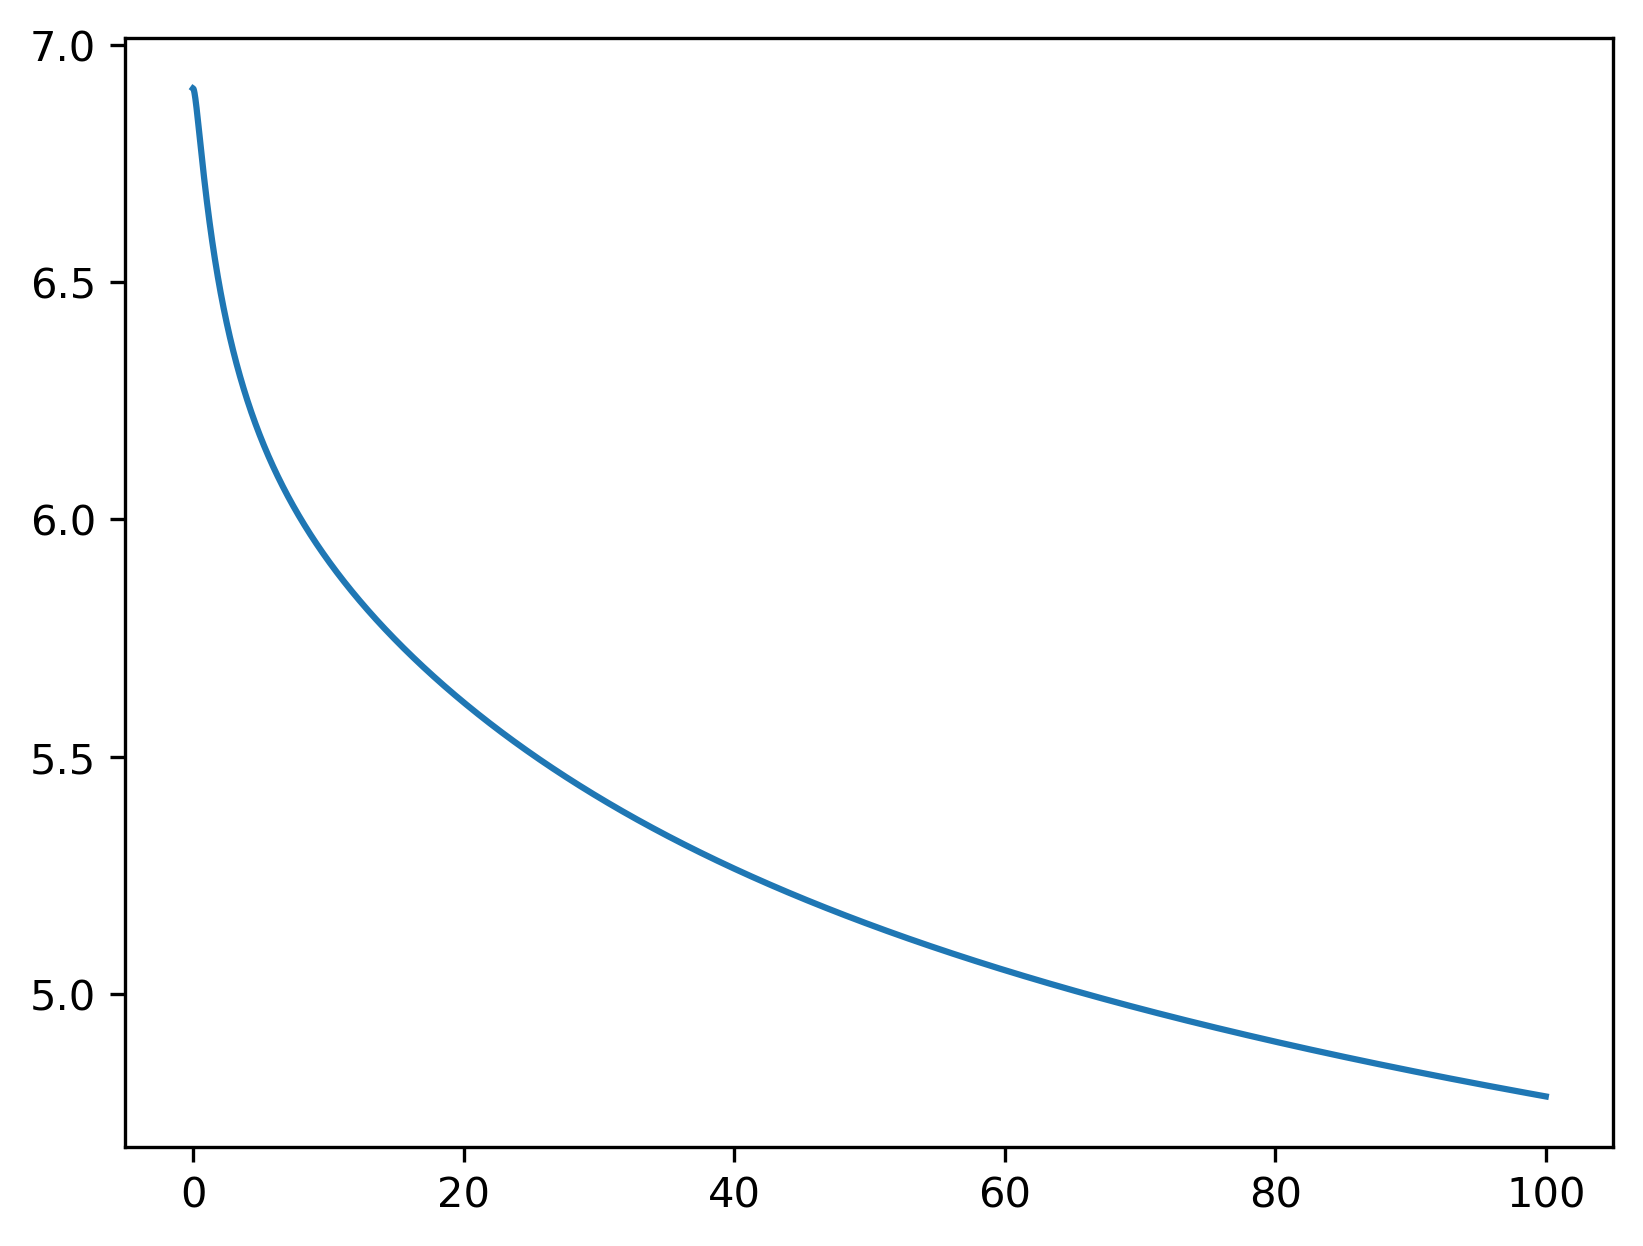

In [4]:
# From WQS: Verify that H in Hbeta is always a dicreasing function in beta
D = np.power(np.random.randn(1000),2)
beta = 0.1
beta_list = np.arange(0, 100, 0.01)
H_list = []
for k in range(0, beta_list.shape[0]):
    H_list.append(Hbeta(D, beta_list[k])[0])

plt.plot(beta_list, np.asarray(H_list))

# Ex.2:
In this exercise, you are supposed to implement the construction of $P_{ij}$. The key is to find approriate $\beta$ for each pieces of data with a bisection search.

See https://en.wikipedia.org/wiki/Bisection_method for the concept of bisection search.


In [108]:
# Write a binary search function to get the approriate beta
def bisection_search_beta(Di, beta, logU, tol, try_lim=50, betamin=-np.inf, betamax=np.inf):
    '''
    Di: the i-th row of D-matrix. Used as the input.
    beta: the beta used for Di.
    logU: the target entropy.
    tol: tolerance for beta
    try_lim: upper limit of times of trial search
    '''
    
    ###################
    # Finish the Code #
    ###################
    
    #------------------------------------------
    # Set the initial state 
    (H, thisP) = Hbeta(Di, beta)
    # Evaluate whether the perplexity is within tolerance
    Hdiff = H - logU
    tries = 0
    
    '''
    beta_list = np.arange(0, 100, 0.01)
    H_list = []
    for k in range(0, beta_list.shape[0]):
        H_list.append(Hbeta(Di, beta_list[k])[0])

    plt.plot(beta_list, np.asarray(H_list))
    plt.show()
    '''
    
    while np.abs(Hdiff) > tol and tries < try_lim:

        # If not, increase or decrease precision
        if Hdiff > 0:
            betamin = beta.copy()
            if betamax == np.inf or betamax == -np.inf:
                beta = beta * 2.
            else:
                beta = (beta + betamax) / 2.
        else:
            betamax = beta.copy()
            if betamin == np.inf or betamin == -np.inf:
                beta = beta / 2.
            else:
                beta = (beta + betamin) / 2.

        # Recompute the values
        (H, thisP) = Hbeta(Di, beta)
        #print(betamin, beta, betamax, H, logU)
        Hdiff = H - logU            
        tries += 1
    #------------------------------------------
    return thisP, beta

#@jax.jit
def jax_bisection_search_beta(Di, beta, logU, tol, try_lim=50, betamin=0, betamax=1e6):
    '''
    Di: the i-th row of D-matrix. Used as the input.
    beta: the beta used for Di.
    logU: the target entropy.
    tol: tolerance for beta
    try_lim: upper limit of times of trial search
    '''
    
    ###################
    # Finish the Code #
    ###################
    
    #------------------------------------------
    # Set the initial state 
    (H, thisP) = Hbeta(Di, beta)
    # Evaluate whether the perplexity is within tolerance
    Hdiff = H - logU
    tries = 0
    def cond_func(val):
        beta, betamin, betamax, Hdiff, tries = val
        return jnp.logical_and(jnp.abs(Hdiff) > tol, tries < try_lim)
    
    def body_func(val):
        beta, betamin, betamax, Hdiff, tries = val
        is_H_possitive = jnp.float32(Hdiff>0)
        betamax = is_H_possitive * betamax + (1-is_H_possitive) * beta
        betamin = is_H_possitive * beta + (1-is_H_possitive) * betamin
        beta = (is_H_possitive * (2 * beta)/2 + (1-is_H_possitive)  * (beta + betamin)/2)
        
        # Recompute the values
        (H, thisP) = Hbeta(Di, beta)
        Hdiff = H - logU            
        tries += 1
        
        return beta, betamin, betamax, Hdiff, tries
    
    init_vals = beta, betamin, betamax, Hdiff, tries
    beta, betamin, betamax, Hdiff, tries = jax.lax.while_loop(cond_func, body_func, init_vals)
    (H, thisP) = Hbeta(Di, beta)
    #------------------------------------------
    return thisP, beta


@jax.jit
def x2D(X,tol=1e-5, perplexity=30.0):
    # Target value of conditional entropy
    (n, d) = X.shape
    sum_X = jnp.sum(jnp.square(X), 1)
    # Get D_ij = \sum_k (x_ik - x_jk)^2
    
    #------------------------------------------
    D = jnp.add(jnp.add(-2 * jnp.dot(X, X.T), sum_X).T, sum_X)
    return D

#@jax.jit
def x2p(X=np.array([]), tol=1e-5, perplexity=3.0):
    """
        Performs a bisection search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    logU = jnp.log(perplexity) # Target value of conditional entropy
    (n, d) = X.shape
    sum_X = jnp.sum(jnp.square(X), 1)
    P = jnp.zeros((n, n))
    beta = jnp.ones(n)
    # Get D_ij = \sum_k (x_ik - x_jk)^2
    
    #------------------------------------------
    print("Computing D")
    D = get_D(X)

    # Loop over all datapoints
    # From WQS: get the bandwidth of Gaussian kernels \beta with bisection searching
    print("Computing D off-diag")
    Di = []
    for i in range(n):
        # Compute the Gaussian kernel and entropy for the current precision
        Di.append(D[i, jnp.concatenate((jnp.r_[0:i], jnp.r_[i+1:n]))])
    Di = jnp.asarray(Di)
    
    print("search for beta")
    search_func = lambda Di, beta: jax_bisection_search_beta(Di, beta, logU, tol)
    thisP, beta = jax.vmap(search_func, (0,0))(Di, beta)
    
    print("Computing P")
    for i in range(n):
        P = P.at[i, jnp.concatenate((jnp.r_[0:i], jnp.r_[i+1:n]))].set(thisP[i])

    # Return final P-matrix
    print("Mean value of sigma: %f" % jnp.mean(jnp.sqrt(1 / beta)))
    P = P + P.transpose()
    sumP = jnp.sum(P)
    P = P/sumP
    #------------------------------------------
    
    return P


In [109]:
X = np.random.randn(10,100)
P = x2p(X)
print(P)

Computing pairwise distances...
Computing D
Computing D off-diag
search for beta
Computing P
Mean value of sigma: 3.472792
[[0.         0.00198397 0.00181119 0.01533736 0.00190451 0.02228104
  0.00421184 0.00070178 0.00042716 0.01287125]
 [0.00198397 0.         0.00752796 0.03126456 0.00191262 0.04756586
  0.0058746  0.00687268 0.00996091 0.0050694 ]
 [0.00181119 0.00752796 0.         0.00207847 0.00961593 0.00205956
  0.020351   0.04026869 0.00771769 0.00334492]
 [0.01533736 0.03126456 0.00207847 0.         0.02737211 0.02287398
  0.00177913 0.00020443 0.02703135 0.0363191 ]
 [0.00190451 0.00191262 0.00961593 0.02737211 0.         0.00036792
  0.00234398 0.00286939 0.00064327 0.01500037]
 [0.02228104 0.04756586 0.00205956 0.02287398 0.00036792 0.
  0.00475834 0.02196342 0.00106406 0.02416543]
 [0.00421184 0.0058746  0.020351   0.00177913 0.00234398 0.00475834
  0.         0.03119746 0.00031675 0.00038291]
 [0.00070178 0.00687268 0.04026869 0.00020443 0.00286939 0.02196342
  0.03119746

In [92]:
X = np.random.randn(10,100)
D = x2D(X)
Di = []
for i in range(0, X.shape[0]):
    Di.append(D[i, jnp.concatenate((jnp.r_[0:i], jnp.r_[i+1:X.shape[0]]))])
beta = jnp.ones(100)

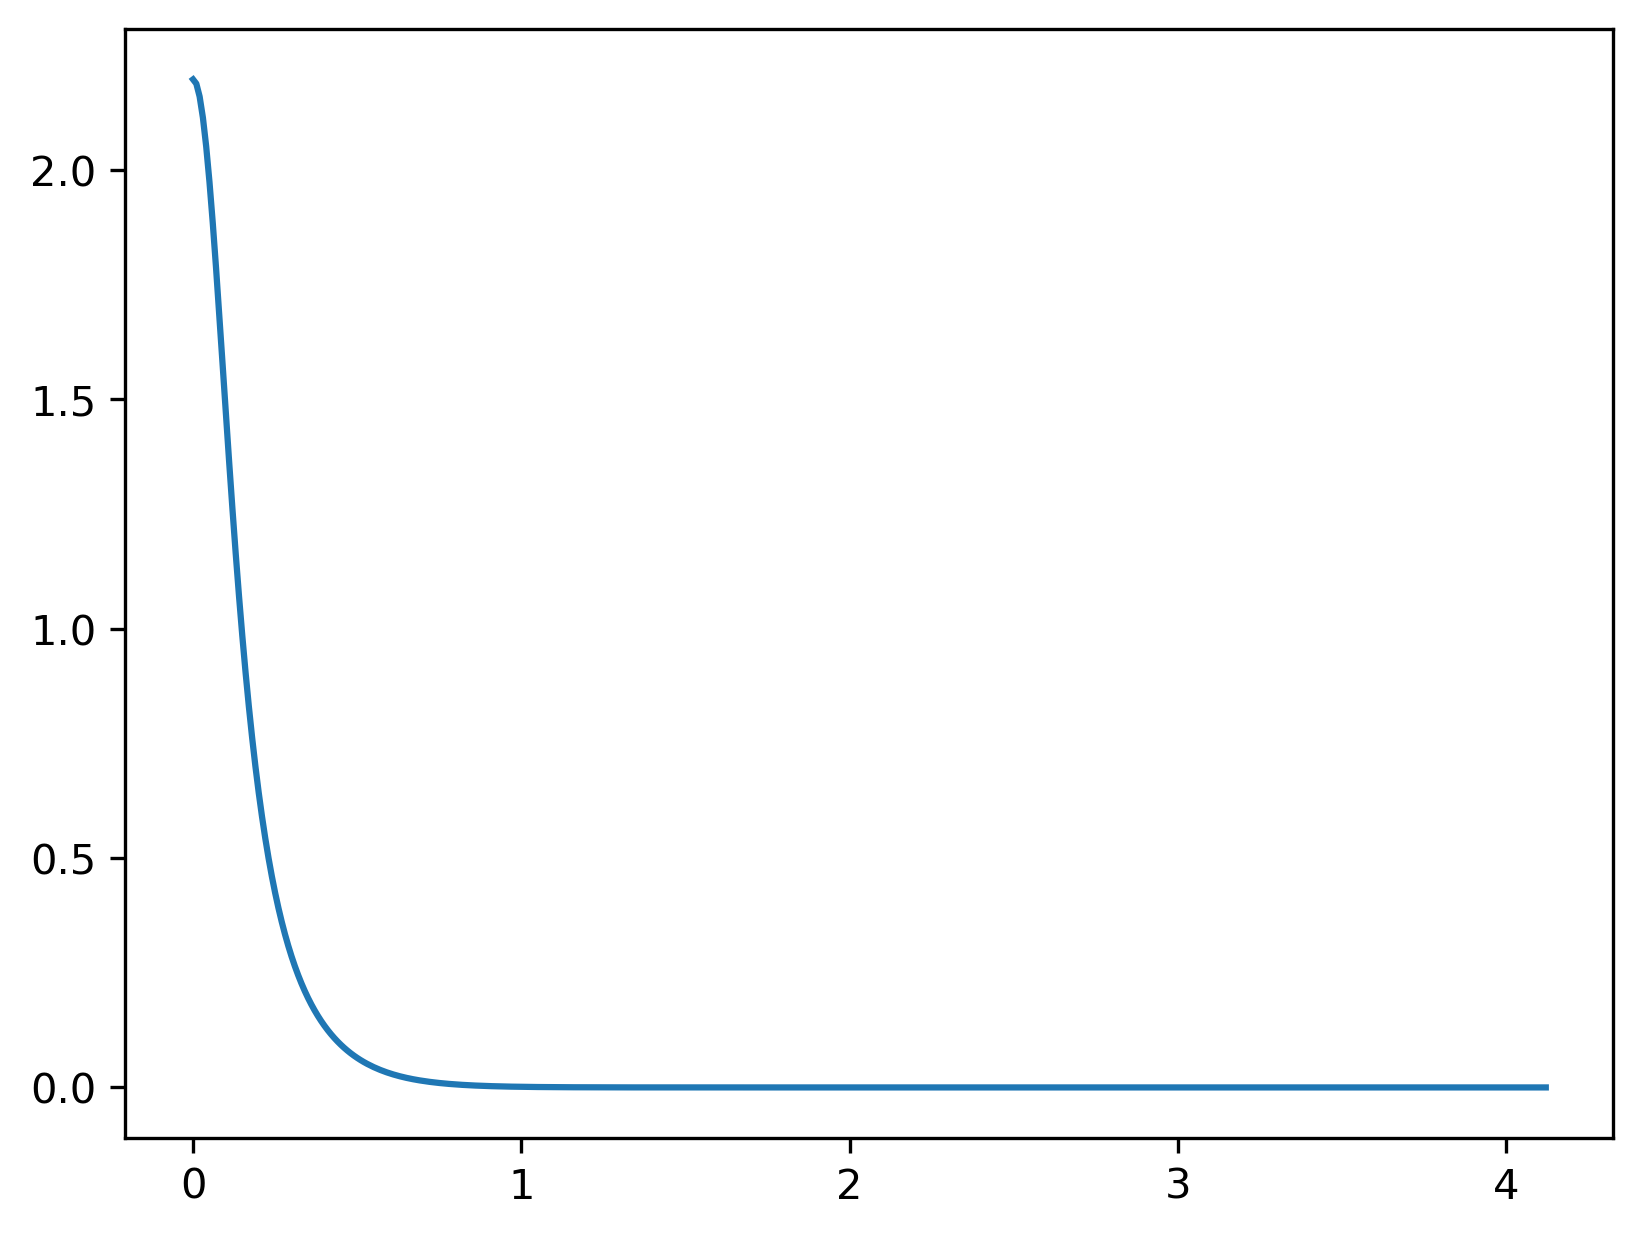

In [93]:
beta_list = np.arange(0, 100, 0.01)
H_list = []
for k in range(0, beta_list.shape[0]):
    H_list.append(Hbeta(Di[0], beta_list[k])[0])
    #print(H_list[-1])

plt.plot(beta_list, np.asarray(H_list))
plt.show()


In [94]:
perplexity = 2
M = x2p(X, perplexity=3)
#print(M)

Computing pairwise distances...
Computing D
Computing D off-diag
search for beta
Computing P
Mean value of sigma: 3.531371


# Ex.3
In this exercise we finish the whole process of t-SNE.

As described above, we need a function to calculate $R_{ij}$ and $Q_{ij}$ (set $R_{ii} = 0$):
\begin{equation}
    \begin{split}
    R_{ij} &= \frac{1}{1 + ||Y_i - Y_j||^2} \\
    Q_{ij} &= \frac{R_{ij}}{\sum_{k,l} R_{kl}}
    \end{split}
\end{equation}

You are supposed to do: 

## Ex.3.1
Finish function "y2Q".

## Ex.3.2

Derive the gradient of probability distance over $Y_i$. Show that we define $L$ as: 

\begin{equation}
L(Y) = \sum_{i \neq j} P_{ij} \log(\frac{P_{ij}}{Q_{ij}(Y)})
\end{equation}

and the process of t-SNE is to find optimal $Y$ through gradient descent:
\begin{equation}
Y^* = \argmax_{Y} L(Y)
\end{equation}

Show that the gradient is ($Y_{ik}$ is the k-th component of $Y_i$):
\begin{equation}
\frac{\partial L}{\partial Y_{ik}} = 4\sum_n (P_{in} - Q_{in}) Q_{in} (Y_{ik} - Y_{nk})
\end{equation}

## Ex.3.3
Based on the equation above, finish function "KLD_and_grad_Y"

In [95]:
def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - jnp.tile(jnp.mean(X, 0), (n, 1))
    (l, M) = jnp.linalg.eig(jnp.dot(X.T, X))
    Y = jnp.dot(X, M[:, 0:no_dims])
    return Y

@jax.jit
def y2Q(Y):
    
    ######################################
    #          Finish the code.          #
    # This return R matrix and Q matrix. #
    ######################################
    
    #------------------------------------------
    n = Y.shape[0]
    sum_Y = jnp.sum(jnp.square(Y), 1)
    num = -2. * jnp.dot(Y, Y.T)
    num = 1. / (1. + jnp.add(jnp.add(num, sum_Y).T, sum_Y))
    num = num * (1-jnp.eye(n))
    #num = num.at[jnp.arange(0,n), jnp.arange(0,n)].set(0.)
    Q = num / jnp.sum(num)
    R = num
    #------------------------------------------
    
    return R, Q

@jax.jit
def KLD_and_grad_Y(P, Y):
    
    ##############################################
    #      Finish the code. This return the      #
    # KL divergence and the gradient of L over Y #
    ##############################################
    
    #------------------------------------------
    n, no_dims = Y.shape
    num, Q = y2Q(Y)
    PQ = P - Q
    C = jnp.sum(P * jnp.log(P / jnp.maximum(Q, 1e-12)))
    dY = jnp.zeros((n, no_dims))
    def single_dY(PQi, numi, Yi, Y):
        return jnp.sum(jnp.tile(PQi * numi, (no_dims, 1)).T * (Yi - Y), 0)
    
    dY = jax.vmap(single_dY, (1,0,0,None))(PQ, num, Y, Y)
    #----------------------------------------------
    return C, dY

def tsne(X=jnp.array([]), no_dims=2, initial_dims=50, perplexity=30.0, 
         do_animation=False, animation_skip_steps=10, max_iter = 1000):
    """
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
        
        Added by F. Marquardt: do_animation==True will give you a graphical animation of
        the progress, use animation_skip_steps to control how often this will
        be plotted; max_iter controls the total number of gradient descent steps
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    # By WQS: use preprocess the data.
    # Preprocess the data with PCA
    #-----------------------------
    X = pca(X, initial_dims).real
    #-----------------------------
    (n, d) = X.shape
    # By WQS: set initial parameters
    eta = 500
    Y = jnp.asarray(np.random.randn(n, no_dims)) # WQS: Output
    iY = 0.* Y

    # Compute P-values
    #----------------------------
    P = x2p(X, 1e-5, perplexity)
    #----------------------------
    #P = P * 4.									# early exaggeration
    P = jnp.maximum(P, 1e-12)
    print(P)

    if do_animation: # added by FM
        costs=jnp.zeros(max_iter) # to store the cost values
        
    # Run iterations
    # WQS: run iterations for gradient descent
    print("tsne start...")
    for iter in range(max_iter):
        
        ##############################################
        # Completet the process of gradient descent. #
        ##############################################
        
        #-----------------------------------------------
        C, dY = KLD_and_grad_Y(P, Y)
        iY = 0.9 * iY - eta * (dY)
        Y = Y + iY
        Y = Y - jnp.tile(jnp.mean(Y, 0), (n, 1))
        #-----------------------------------------------

        # These lines below plot the process of training with animation
        if not do_animation: # added by FM: do not print if we are animating!
            # Compute current value of cost function
            if (iter + 1) % 10 == 0:
                print("Iteration %d: error is %f" % (iter + 1, C), end="           \r") # modified to overwrite line

        # Stop lying about P-values
        if iter == 100:
            #P = P / 4.
            pass
            
        if do_animation:  # added by FM
            costs = costs.at[iter].set(C)
            if iter % animation_skip_steps==0:
                clear_output(wait=True)
                fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(10,5))
                ax[0].plot(costs)
                ax[1].scatter(Y[:,0],Y[:,1],color="orange")
                plt.show()

    # Return solution
    return Y

In [96]:
jnp.eye(10)

Array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float64)

In [97]:
X = np.random.randn(100,10)
P = x2p(X)

Computing pairwise distances...
Computing D
Computing D off-diag
search for beta
Computing P
Mean value of sigma: 1.973137


# Example 1: A few Gaussian clouds in high-dimensional space

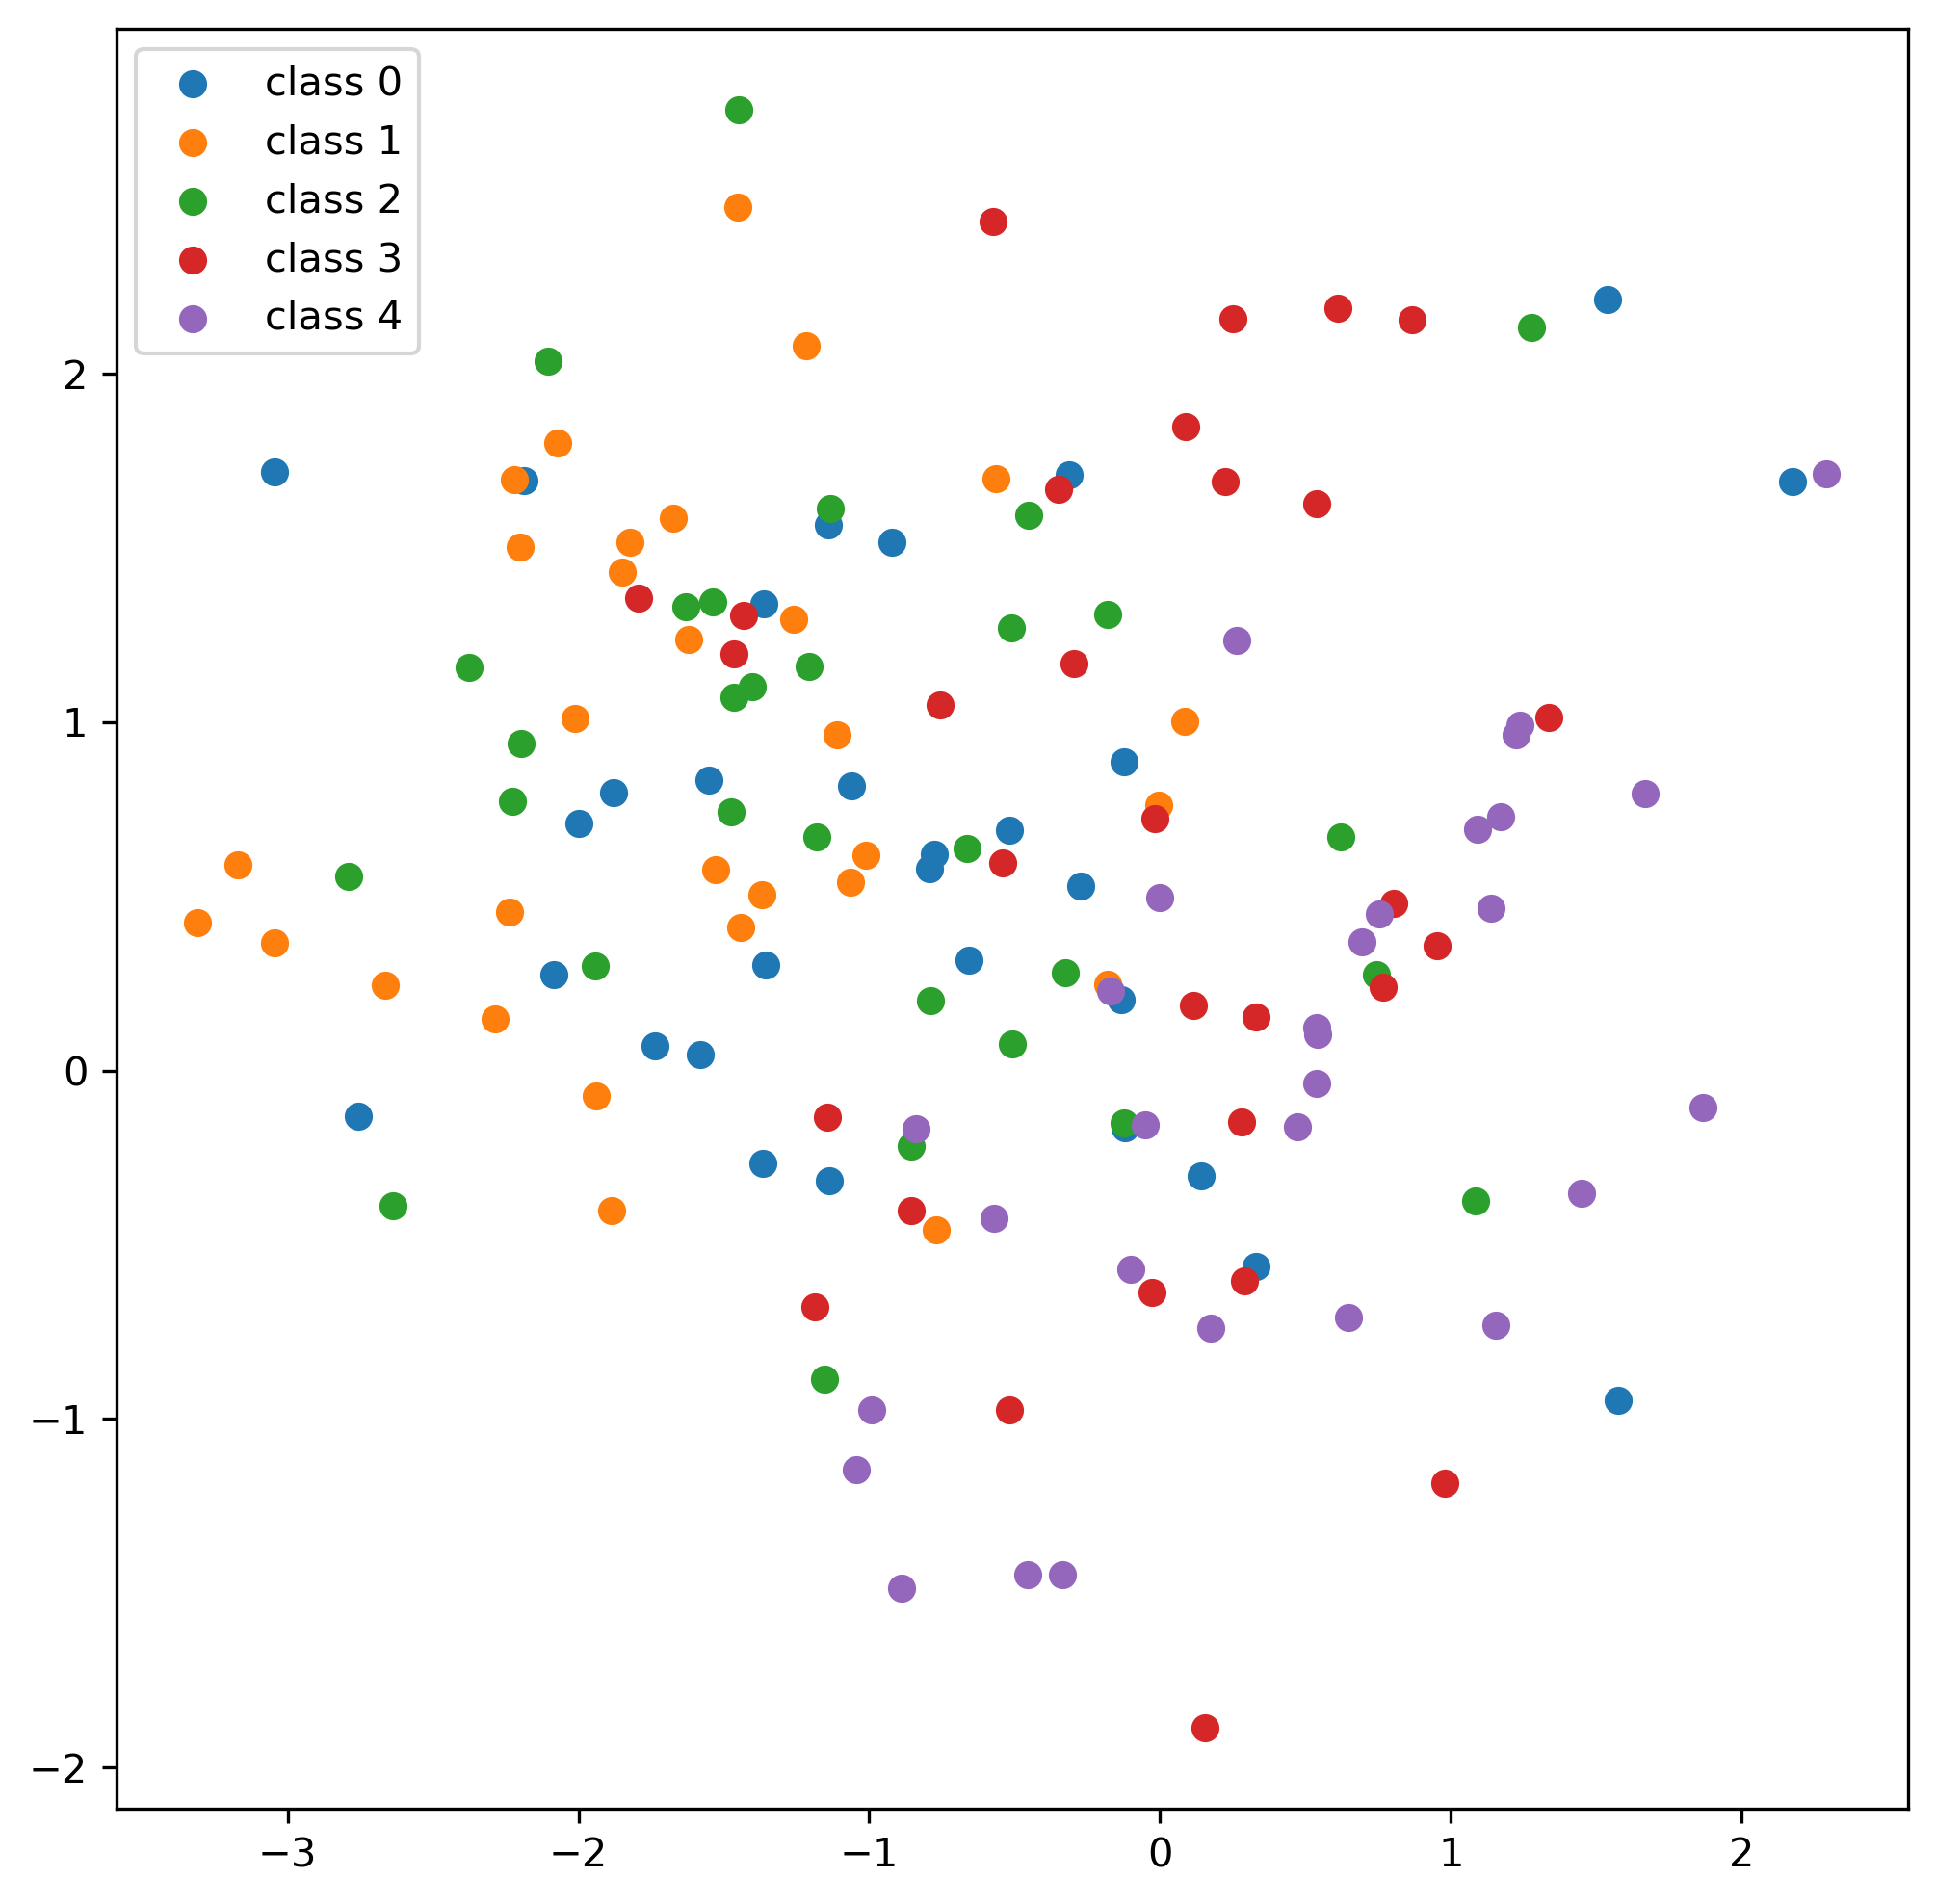

In [98]:
# produce a high-dimensional data set, composed of a few Gaussian point clouds in high-dimensional space

n_dim=100 # a really high-dimensional space

n_clusters=5 # number of clusters, i.e. clouds
N_cluster_points=30 # number of points inside each cluster
N=n_clusters*N_cluster_points # total number of points

Gauss_spread=1.0 # size of each cluster (cloud)

X=np.zeros([N,n_dim])

for j in range(n_clusters):
    Xmean=np.random.randn(n_dim) # the center position of the cluster
    X[j*N_cluster_points:(j+1)*N_cluster_points,:]=Xmean[None,:]+Gauss_spread*np.random.randn(N_cluster_points,n_dim)

# plot these points in a projection into 2D space
# color them according to the cluster they belong to!

plt.figure(figsize=(8,8))
for j in range(n_clusters):
    X0=X[j*N_cluster_points:(j+1)*N_cluster_points,0]
    X1=X[j*N_cluster_points:(j+1)*N_cluster_points,1]    
    plt.scatter(X0,X1,label='class {0}'.format(j))
plt.legend()
plt.show()

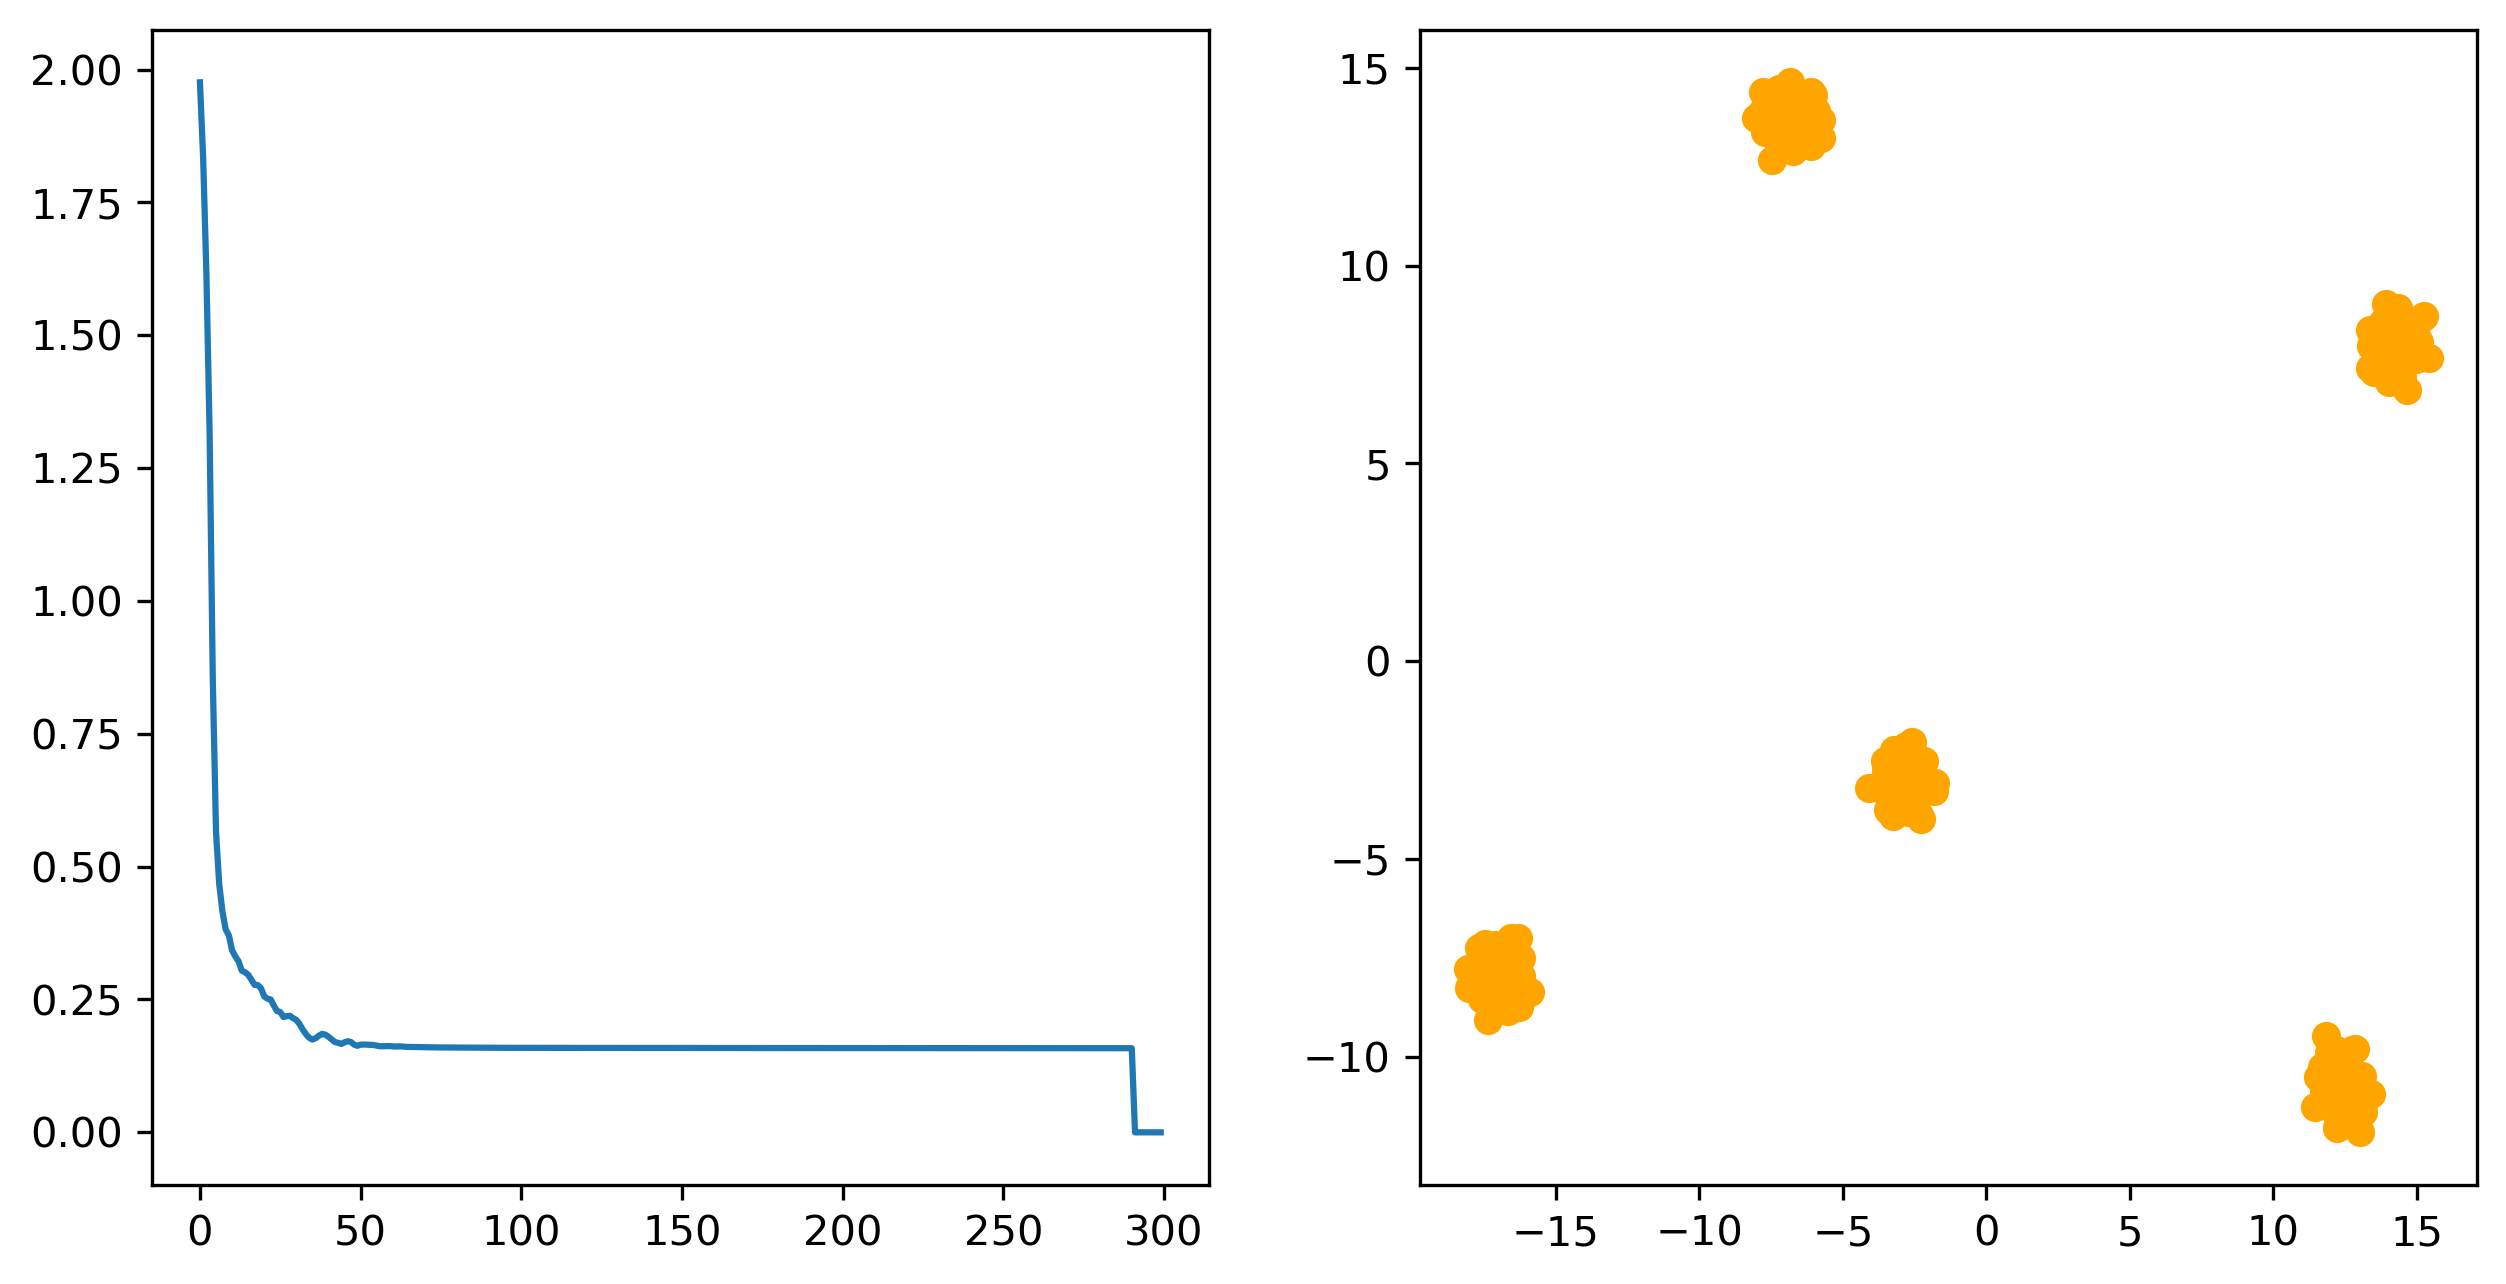

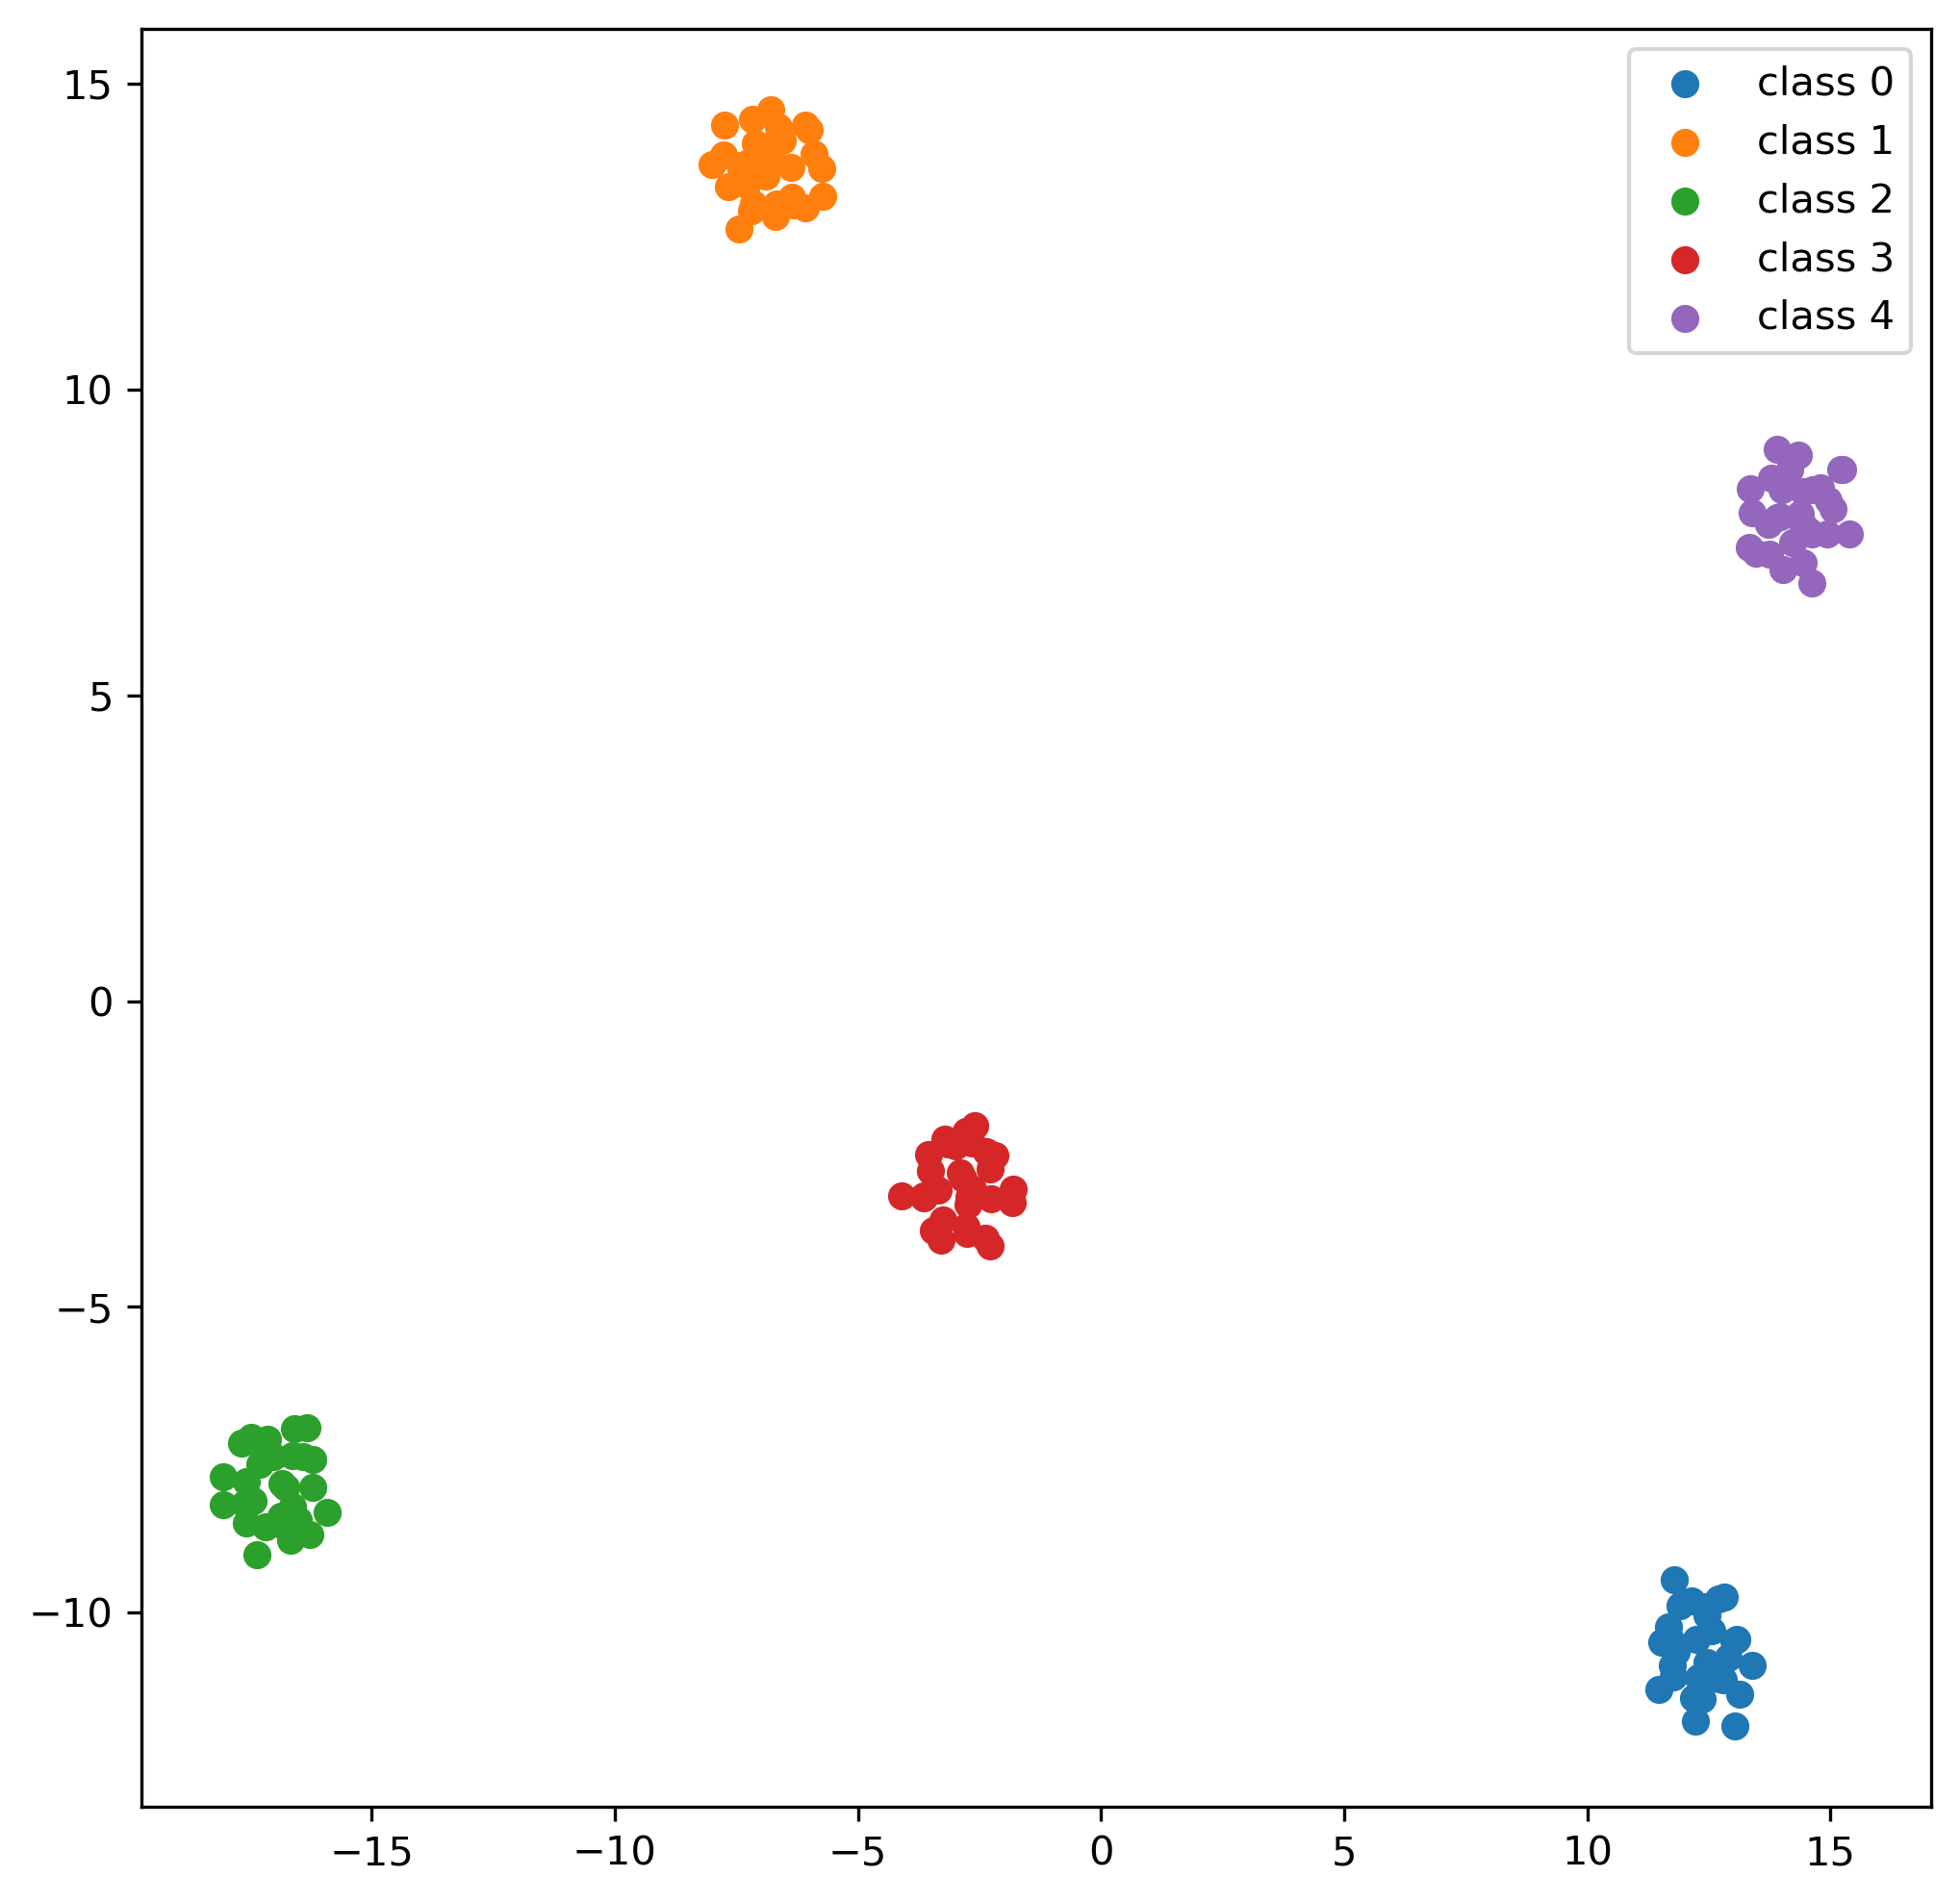

In [99]:
# now apply t-SNE to reduce to two dimensions in a smart way!
Y=tsne(X, no_dims=2, initial_dims=50, perplexity=20.0, 
       do_animation=True, animation_skip_steps=10, max_iter=300)

# plot the points according to the t-SNE projection into 2D space
# color them according to the cluster they belong to!
plt.figure(figsize=(8,8))
for j in range(n_clusters):
    Y0=Y[j*N_cluster_points:(j+1)*N_cluster_points,0]
    Y1=Y[j*N_cluster_points:(j+1)*N_cluster_points,1]    
    plt.scatter(Y0,Y1,label='class {0}'.format(j))
plt.legend()
plt.show()

# Example 2: Multiple Gaussians: finding the true number without labels!

In [100]:
# Plot a tSNE-scatterplot, but with some randomly marked points,
# together with the corresponding high-dimensional data points plotted
# as curves!

def plot_tsne_with_curves(y0,y1,x,xlabel,n_picks=10,vmin=-0.1,vmax=2):
    random_picks=np.random.randint(np.shape(y0)[0],size=n_picks) # pick some random points
    
    fig=plt.figure(constrained_layout=True,figsize=(8,4))
    gs=fig.add_gridspec(ncols=8,nrows=4)
    scatter_plot=fig.add_subplot(gs[0:4,0:4])
    
    myplot={}
    j=0
    for n0 in range(4):
        for n1 in range(4):
            myplot[j]=fig.add_subplot(gs[n0,4+n1])
            myplot[j].axis('off')
            j+=1
    
    scatter_plot.scatter(y0,y1,c=xlabel)
    scatter_plot.scatter(y0[random_picks],y1[random_picks],color="black",alpha=0.7,s=80)
    
    for idx in range(len(random_picks)):
        scatter_plot.text(y0[random_picks[idx]], y1[random_picks[idx]], 
                      str(idx), fontsize=8, color="orange", 
                     alpha=0.8, horizontalalignment='center',
                verticalalignment='center')
    
    for idx,m in enumerate(random_picks):
        if idx<j:
            myplot[idx].plot(x[m,:])
            myplot[idx].text(0.1, 0.75, str(idx), fontsize=12, color="orange", 
                             alpha=0.5, horizontalalignment='center',
                        verticalalignment='center', transform=myplot[idx].transAxes)
            myplot[idx].set_ylim([vmin,vmax])
        
    plt.show()

In [101]:
def my_generator1D(batchsize,x): # produce a batch of curves, a random number of Gaussian
    maxNum=2 # the maximum number of Gaussians
    NumGaussians=np.random.randint(maxNum+1,size=batchsize) # select the number, for each sample
    Curves=np.zeros([batchsize,len(x)])
    for j in range(maxNum):
        R=np.random.uniform(low=0.1,high=0.11,size=batchsize) # width
        A=np.random.uniform(low=0.9,high=1.0,size=batchsize) # amplitude
        x0=np.random.uniform(size=batchsize,low=-0.8,high=0.8) # position
        Curves+=(j<=NumGaussians[:,None]-1)*A[:,None]*np.exp(-((x[None,:]-x0[:,None])/R[:,None])**2)
    Curves+=0.1*np.random.randn(batchsize,len(x)) # add a bit of background noise on top
    return( Curves, NumGaussians )

n_dim=100
x=np.linspace(-1,1,n_dim)
N=2000 # how many curves

X,Xlabel=my_generator1D(N,x) 
# small x is the coordinate, capital X are the high-dim. "data points", meaning samples of curves!



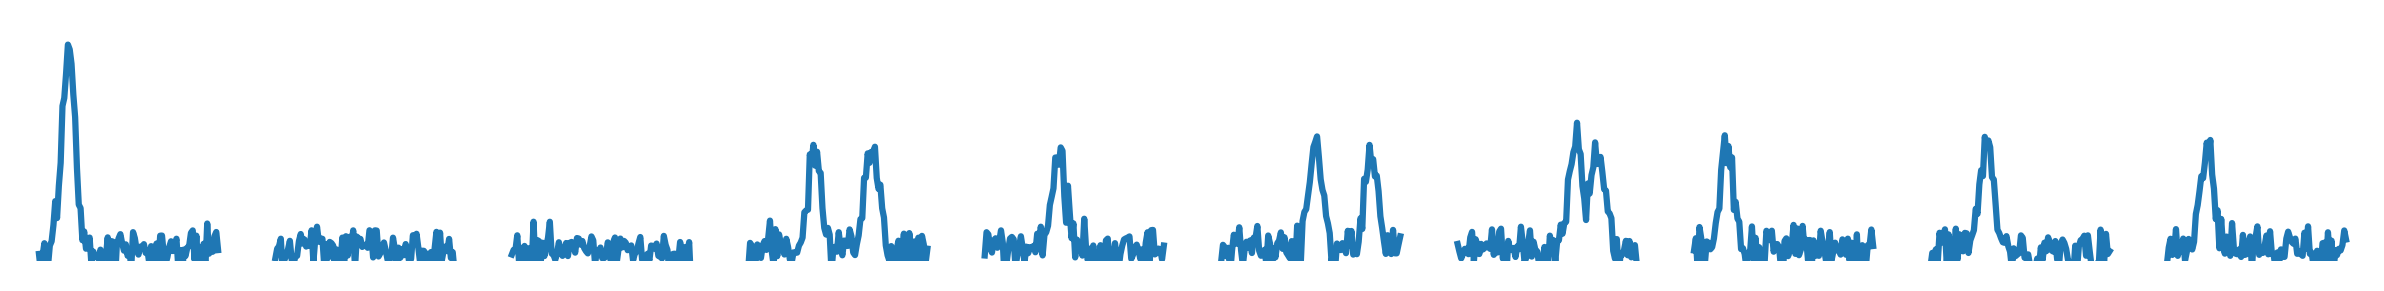

In [102]:
fig,ax=plt.subplots(ncols=10,nrows=1,figsize=(10,1))
for n in range(10):
    ax[n].plot(X[n,:])
    ax[n].set_ylim([-0.1,2])
    ax[n].axis('off')
plt.show()

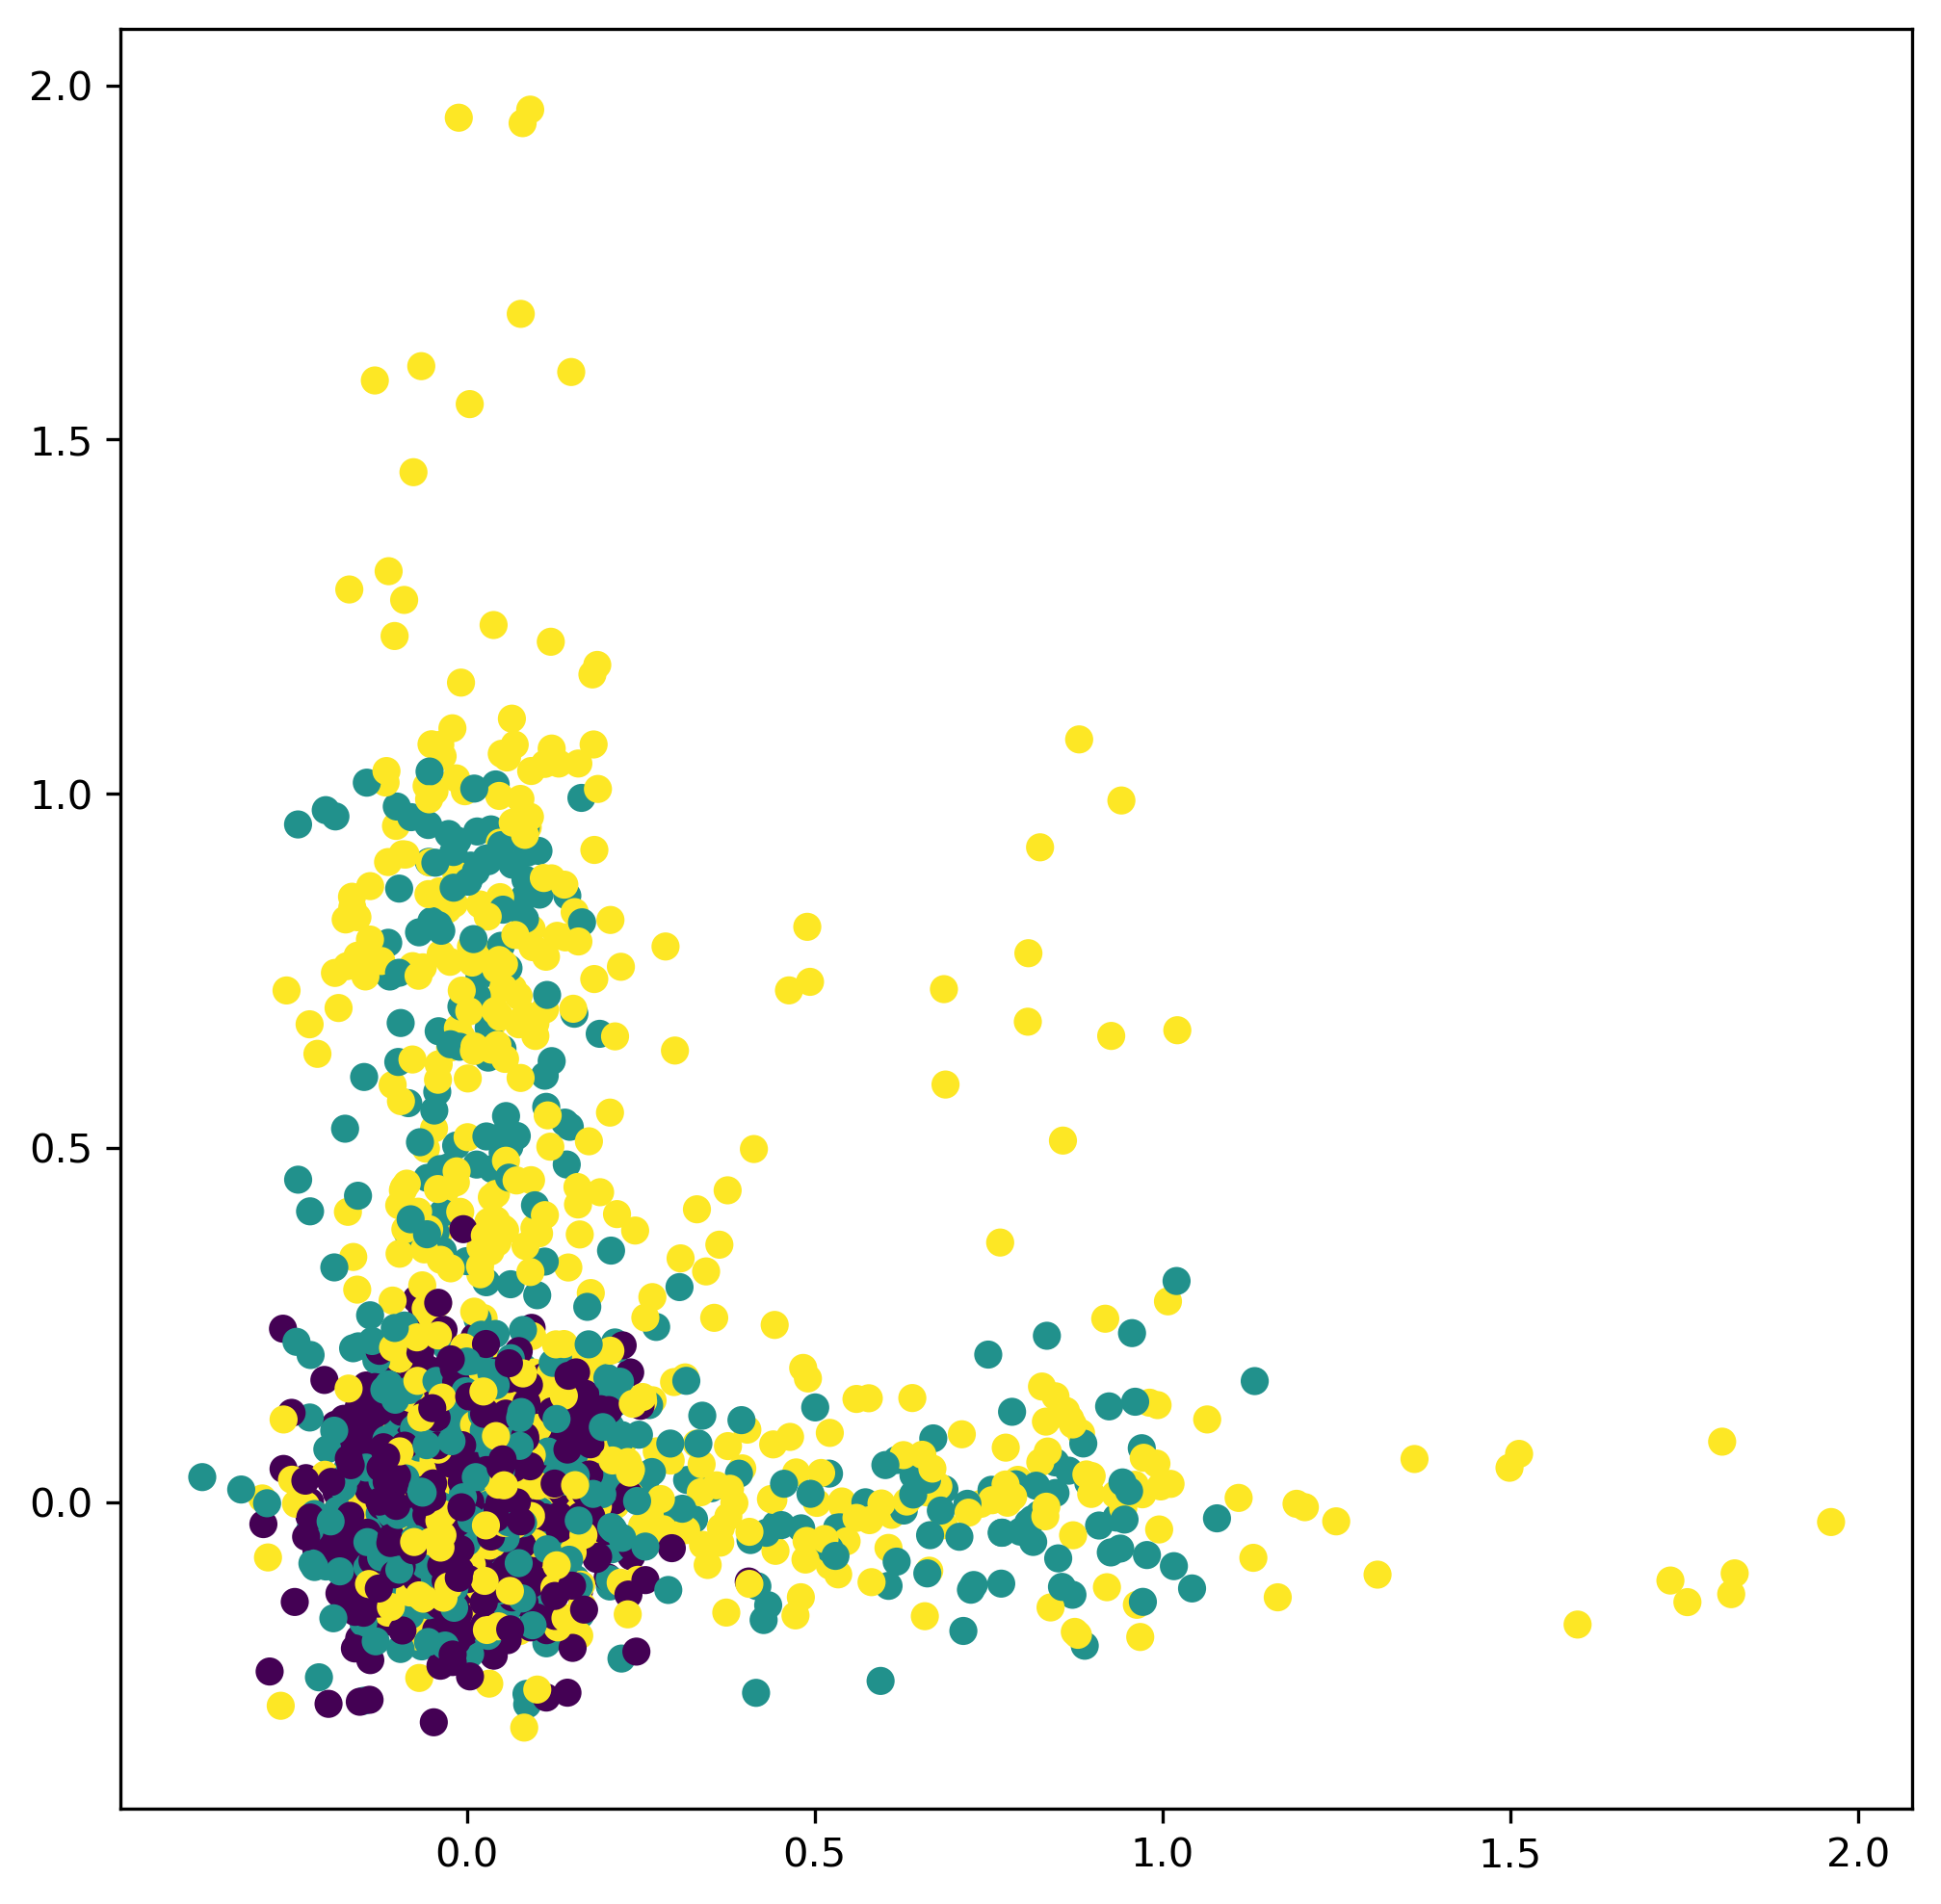

In [103]:
# plot these points in a projection into 2D space

# pick two arbitrary coordinates
j0=17
j1=35

plt.figure(figsize=(8,8))
X0=X[:,j0]
X1=X[:,j1]    
plt.scatter(X0,X1,c=Xlabel)
plt.show()

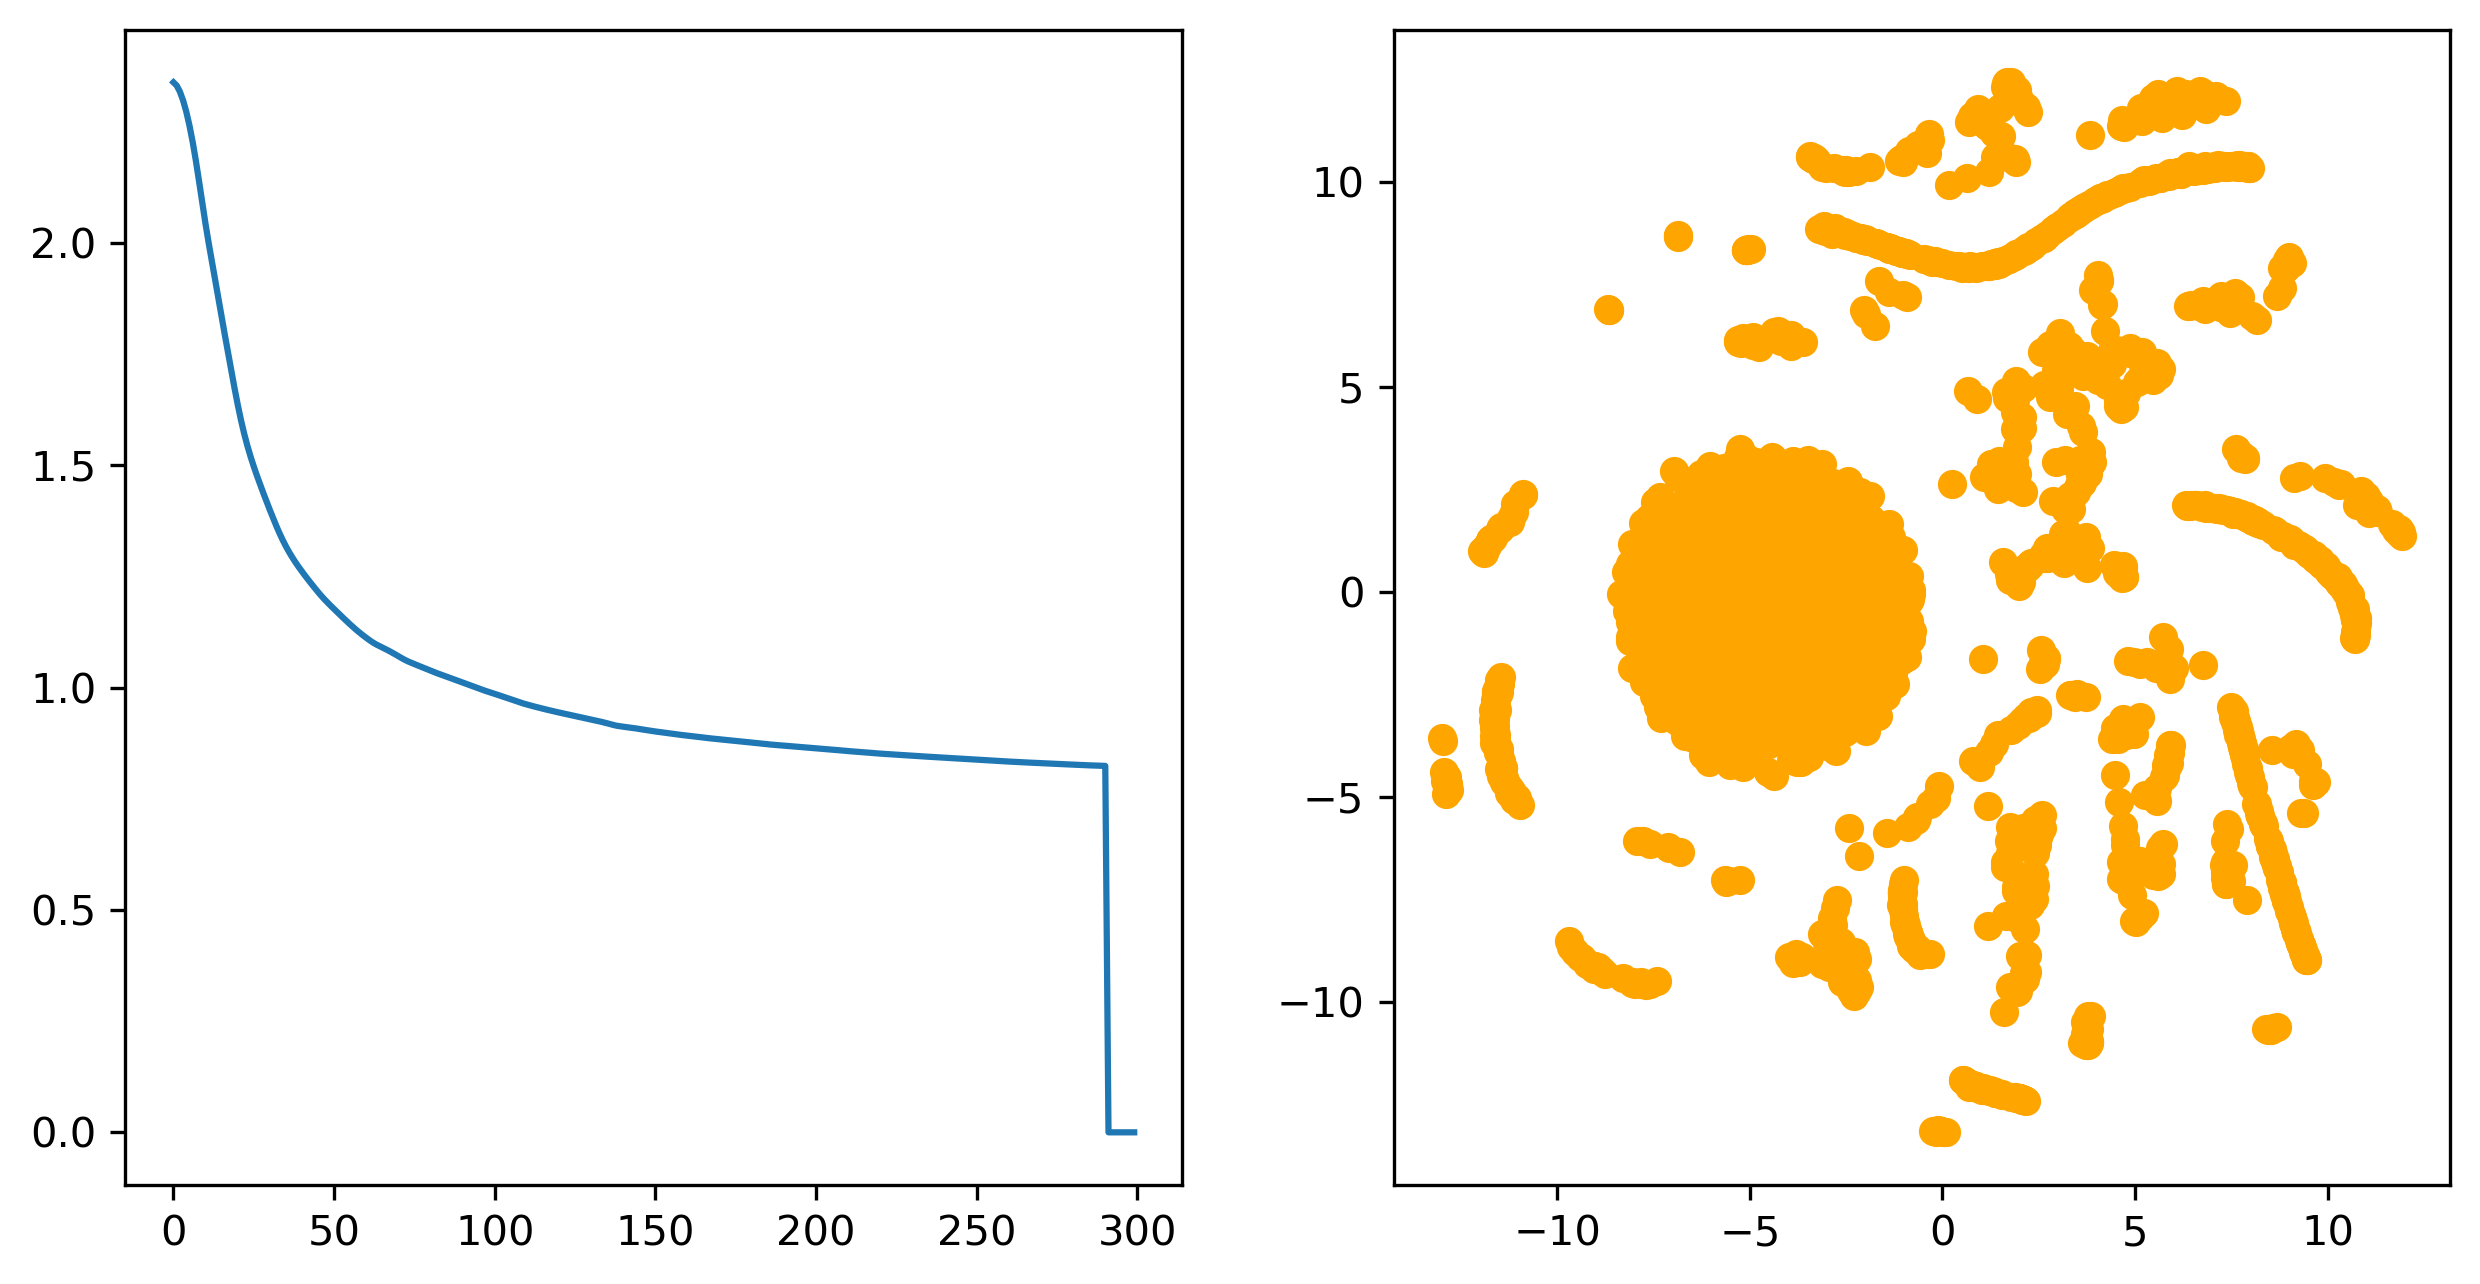

In [104]:
# now apply t-SNE to reduce to two dimensions in a smart way!
Y=tsne(X, 2, 20, 30.0, do_animation=True, animation_skip_steps=10, max_iter=300)

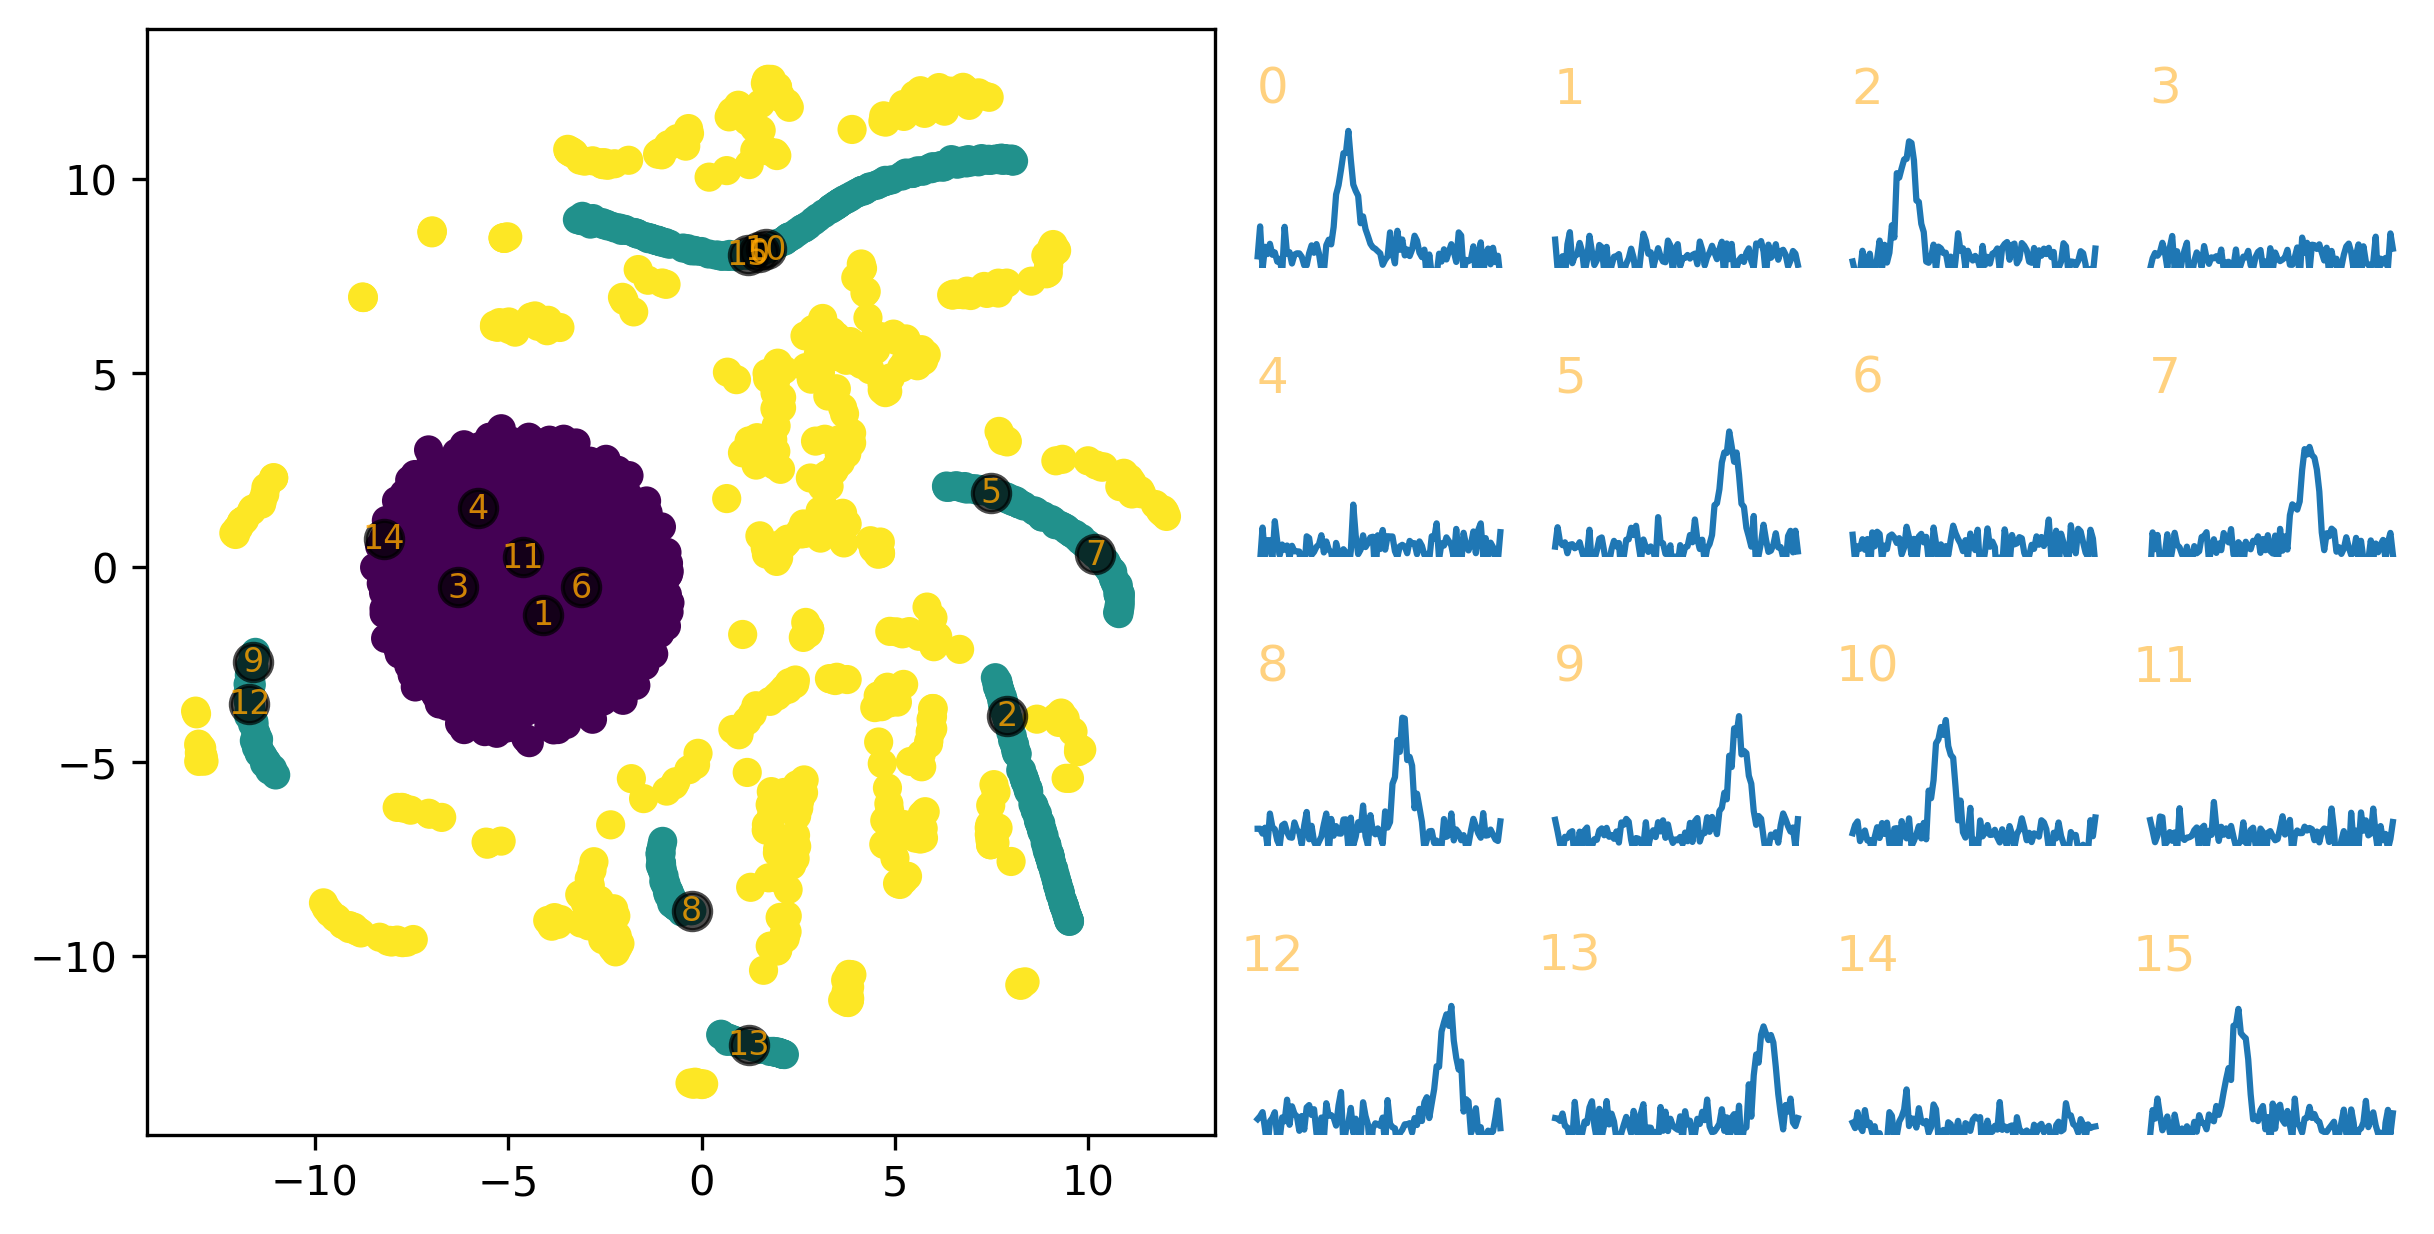

In [105]:
plot_tsne_with_curves(Y[:,0],Y[:,1],X,Xlabel,n_picks=16)

# Bonus Exercise 2: Change the perplexity parameter in the 'Gaussian cloud' example and/or the 'multiple Gaussians' example and observe its effect!



# Bonus Exercise 3: Modify the 'multiple Gaussians' example by inventing different sample curves

